In [10]:
import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import ipaddress

In [11]:
def convert_ip2int(ip):
    return int(ipaddress.ip_address(ip))

In [12]:
DROP_COLS = []  # 실제 컬럼명에 맞게 정리
BAD_RATE_COLS = []           # 필요시 더 추가

def make_sequences(df, time_steps=20):
    # 1) Timestamp 파싱/정렬
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce', utc=True)
    df = df.dropna(subset=['Timestamp']).sort_values('Timestamp')

    # 2) 라벨 이진화
    df['Label'] = (df['Label'] != 'BENIGN').astype(int)
    
    # 3) IP 주소 정수 변환
    df['Source IP'] = df['Source IP'].astype(str).apply(convert_ip2int)
    df['Destination IP'] = df['Destination IP'].astype(str).apply(convert_ip2int)

    # 4) 식별자/문제 컬럼 제거
    drop_cols = [c for c in DROP_COLS if c in df.columns] + [c for c in BAD_RATE_COLS if c in df.columns]
    df = df.drop(columns=drop_cols, errors='ignore')

    # 5) 수치형만 사용, inf/NaN 정리
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna()  # or feature-wise impute

    # 6) 슬라이딩 윈도우 (전역 흐름 순서 기준; 필요 시 Source IP 등으로 groupby 후 적용)
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    X, y = [], []
    vals = df[num_cols].values
    labels = df['Label'].values
    for i in range(len(df) - time_steps + 1):
        X.append(vals[i:i+time_steps])
        y.append(labels[i + time_steps-1])
    
    return np.asarray(X), np.asarray(y)

In [13]:
data_path = 'dataset/'
all_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
train_files = [f for f in all_files if 'Wednesday' not in f]
test_files = [f for f in all_files if 'Wednesday' in f]

TIME_STEPS = 10

X_train_list, y_train_list = [], []
for file_name in train_files:
    file_path = os.path.join(data_path, file_name)
    df = pd.read_csv(file_path, encoding='latin1', low_memory=False, on_bad_lines='skip')
    df.columns = df.columns.str.strip()

    X_temp, y_temp = make_sequences(df, time_steps=TIME_STEPS)
    X_train_list.append(X_temp)
    y_train_list.append(y_temp)

X_test_list, y_test_list = [], []
for file_name in test_files:
    file_path = os.path.join(data_path, file_name)
    df = pd.read_csv(file_path, encoding='latin1', low_memory=False, on_bad_lines='skip')
    df.columns = df.columns.str.strip()

    X_temp, y_temp = make_sequences(df, time_steps=TIME_STEPS)
    X_test_list.append(X_temp)
    y_test_list.append(y_temp)

X_train_seq = np.concatenate(X_train_list, axis=0)
y_train_seq = np.concatenate(y_train_list, axis=0)
X_test_seq = np.concatenate(X_test_list, axis=0)
y_test_seq = np.concatenate(y_test_list, axis=0)

scaler = MinMaxScaler()

nsamples, nsteps, nfeatures = X_train_seq.shape
X_train_2d = X_train_seq.reshape((nsamples * nsteps, nfeatures))
X_train_scaled_2d = scaler.fit_transform(X_train_2d)
X_train_scaled_seq = X_train_scaled_2d.reshape((nsamples, nsteps, nfeatures))

nsamples_test, nsteps_test, nfeatures_test = X_test_seq.shape
X_test_2d = X_test_seq.reshape((nsamples_test * nsteps_test, nfeatures_test))
X_test_scaled_2d = scaler.transform(X_test_2d)
X_test_scaled_seq = X_test_scaled_2d.reshape((nsamples_test, nsteps_test, nfeatures_test))

print(f"학습 데이터 형태: {X_train_seq.shape}, {y_train_seq.shape}")
print(f"테스트 데이터 형태: {X_test_seq.shape}, {y_test_seq.shape}")
print("-" * 50)

학습 데이터 형태: (2136407, 10, 83), (2136407,)
테스트 데이터 형태: (691397, 10, 83), (691397,)
--------------------------------------------------


In [14]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weights_dict = dict(enumerate(class_weights))

print(f"클래스 가중치: {class_weights_dict}")

클래스 가중치: {0: 0.5832161299516154, 1: 3.504225264325057}


In [15]:
## LSTM
def create_lstm_model(input_shape, lstm_units=100, dense_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, activation='tanh', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("LSTM 모델 학습 시작...")
LSTM_starttime = time.time()

input_shape = (X_train_scaled_seq.shape[1], X_train_scaled_seq.shape[2])

lstm_model = create_lstm_model(input_shape=input_shape)

history = lstm_model.fit(
    X_train_scaled_seq,
    y_train_seq,
    epochs=10,
    batch_size=32,
    verbose=1,
    class_weight=class_weights_dict
)
LSTM_endtime = time.time()
LSTM_time = LSTM_endtime - LSTM_starttime
print("LSTM 모델 학습 완료.")

LSTM 모델 학습 시작...
Epoch 1/10
66763/66763 [==============================] - 411s 6ms/step - loss: 0.0011 - accuracy: 0.9998
Epoch 2/10
66763/66763 [==============================] - 406s 6ms/step - loss: 2.3272e-10 - accuracy: 1.0000
Epoch 3/10
66763/66763 [==============================] - 406s 6ms/step - loss: 2.5399e-05 - accuracy: 1.0000
Epoch 4/10
66763/66763 [==============================] - 408s 6ms/step - loss: 1.6316e-10 - accuracy: 1.0000
Epoch 5/10
66763/66763 [==============================] - 407s 6ms/step - loss: 4.7691e-12 - accuracy: 1.0000
Epoch 6/10
66763/66763 [==============================] - 408s 6ms/step - loss: 2.2409e-11 - accuracy: 1.0000
Epoch 7/10
66763/66763 [==============================] - 407s 6ms/step - loss: 3.2474e-12 - accuracy: 1.0000
Epoch 8/10
66763/66763 [==============================] - 407s 6ms/step - loss: 1.4276e-12 - accuracy: 1.0000
Epoch 9/10
66763/66763 [==============================] - 407s 6ms/step - loss: 6.1386e-13 - accuracy: 1.00

In [16]:

y_pred_lstm_prob = lstm_model.predict(X_test_scaled_seq).flatten()
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)
accuracy_lstm = accuracy_score(y_test_seq, y_pred_lstm)
recall_lstm = recall_score(y_test_seq, y_pred_lstm)
f1_lstm = f1_score(y_test_seq, y_pred_lstm)
report = classification_report(y_test_seq, y_pred_lstm, target_names=['BENIGN (0)', 'ATTACK (1)'])

print("\nEvaluating model performance on the Test set...")
# Predict on the separate test set
print(f"\n--- LSTM Results---")
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Recall:   {recall_lstm:.4f}")
print(f"F1-Score: {f1_lstm:.4f}")
print("\nClassification Report:")
print(report)

21607/21607 [==============================] - 45s 2ms/step

Evaluating model performance on the Test set...

--- LSTM Results---
Accuracy: 1.0000
Recall:   1.0000
F1-Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

  BENIGN (0)       1.00      1.00      1.00    439674
  ATTACK (1)       1.00      1.00      1.00    251723

    accuracy                           1.00    691397
   macro avg       1.00      1.00      1.00    691397
weighted avg       1.00      1.00      1.00    691397



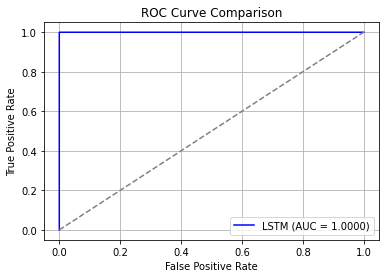

In [17]:
## ROC Curve
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve


fpr_lstm, tpr_lstm, _ = roc_curve(y_test_seq, y_pred_lstm_prob)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, color='blue', label=f'LSTM (AUC = {roc_auc_lstm:.4f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

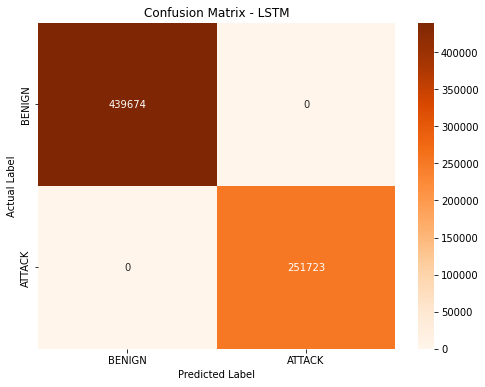

In [18]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_lstm = confusion_matrix(y_test_seq, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Oranges', xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
plt.title('Confusion Matrix - LSTM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()